<a href="https://colab.research.google.com/github/FabianaAlbuquerque97/temporal-probabilistic-models/blob/main/Rede_Bayesiana_Din%C3%A2mica_(DBN)_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rede Bayesiana Dinâmica (DBN)

Modelar a progressão dos sintomas ao longo do tempo e como eles se relacionam com o estado oculto da doença (COVID-19, Gripe, Pneumonia).

In [ ]:
!pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
# Importação das bibliotecas necessárias
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import DBNInference
import seaborn as sns
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import numpy as np


In [ ]:
# Criação do modelo de Rede Bayesiana Dinâmica (DBN)

# Cada variável é representada por um par (variável, tempo).
# Aqui modelamos a relação entre a Doença e os sintomas: Febre, Tosse, Fadiga.

# A doença no tempo 0 influencia os sintomas no tempo 0.
# A doença no tempo 0 também influencia a própria doença no tempo 1, modelando a progressão temporal.
# A doença no tempo 1 influencia os sintomas no tempo 1.

model = DBN()

model.add_edges_from([
    (('Doenca', 0), ('Febre', 0)),
    (('Doenca', 0), ('Tosse', 0)),
    (('Doenca', 0), ('Fadiga', 0)),
    (('Doenca', 0), ('Doenca', 1)),
    (('Doenca', 1), ('Febre', 1)),
    (('Doenca', 1), ('Tosse', 1)),
    (('Doenca', 1), ('Fadiga', 1)),
])


In [ ]:
# Definição das CPDs (Distribuições de Probabilidade Condicional) no tempo 0

# 'Doenca' possui 3 estados: Gripe, COVID-19, Pneumonia.
# Os sintomas são binários: Presença (1) ou Ausência (0).

cpd_doenca_0 = TabularCPD(('Doenca', 0), 3, [[0.3], [0.5], [0.2]])  # Priori: Gripe 30%, COVID-19 50%, Pneumonia 20%

# Probabilidades condicionais dos sintomas, dado o estado da doença.
cpd_febre_0 = TabularCPD(('Febre', 0), 2,
                         [[0.9, 0.7, 0.6],  # P(Febre=0 | Doenca)
                          [0.1, 0.3, 0.4]], # P(Febre=1 | Doenca)
                         evidence=[('Doenca', 0)],
                         evidence_card=[3])

cpd_tosse_0 = TabularCPD(('Tosse', 0), 2,
                         [[0.7, 0.4, 0.3],
                          [0.3, 0.6, 0.7]],
                         evidence=[('Doenca', 0)],
                         evidence_card=[3])

cpd_fadiga_0 = TabularCPD(('Fadiga', 0), 2,
                          [[0.8, 0.5, 0.4],
                           [0.2, 0.5, 0.6]],
                          evidence=[('Doenca', 0)],
                          evidence_card=[3])


In [ ]:
# Transição da doença do tempo 0 para o tempo 1
cpd_doenca_trans = TabularCPD(('Doenca', 1), 3,
                               [[0.7, 0.2, 0.1],   # P(Doenca=Gripe | Doenca_t-1)
                                [0.1, 0.7, 0.2],   # P(Doenca=COVID-19 | Doenca_t-1)
                                [0.2, 0.1, 0.7]],  # P(Doenca=Pneumonia | Doenca_t-1)
                               evidence=[('Doenca', 0)],
                               evidence_card=[3])

# CPDs dos sintomas no tempo 1, mesma lógica do tempo 0
cpd_febre_1 = TabularCPD(('Febre', 1), 2,
                         [[0.85, 0.6, 0.5],
                          [0.15, 0.4, 0.5]],
                         evidence=[('Doenca', 1)],
                         evidence_card=[3])

cpd_tosse_1 = TabularCPD(('Tosse', 1), 2,
                         [[0.6, 0.3, 0.2],
                          [0.4, 0.7, 0.8]],
                         evidence=[('Doenca', 1)],
                         evidence_card=[3])

cpd_fadiga_1 = TabularCPD(('Fadiga', 1), 2,
                          [[0.75, 0.55, 0.35],
                           [0.25, 0.45, 0.65]],
                          evidence=[('Doenca', 1)],
                          evidence_card=[3])


In [ ]:
# Adicionando as CPDs ao modelo

model.add_cpds(cpd_doenca_0,
               cpd_febre_0,
               cpd_tosse_0,
               cpd_fadiga_0,
               cpd_doenca_trans,
               cpd_febre_1,
               cpd_tosse_1,
               cpd_fadiga_1)


In [ ]:
# Verificação se o modelo está bem definido
assert model.check_model(), "O modelo está incorreto!"


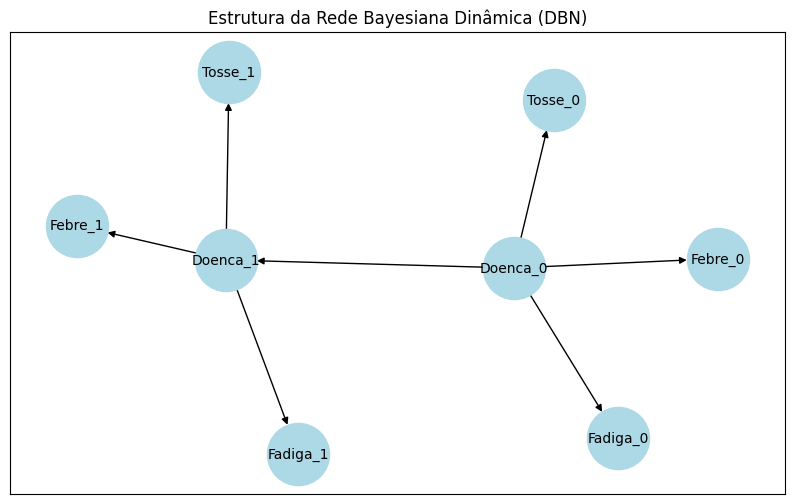

In [ ]:
# Criar grafo dirigido
G = nx.DiGraph()

# Adicionando os nós
for node in model.nodes():
    G.add_node(f"{node[0]}_{node[1]}")  # node é uma tupla: (nome, tempo)

# Adicionando as arestas
for edge in model.edges():
    from_node = f"{edge[0][0]}_{edge[0][1]}"
    to_node = f"{edge[1][0]}_{edge[1][1]}"
    G.add_edge(from_node, to_node)

# Plotando o grafo
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)  # layout estável
nx.draw_networkx(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, arrows=True)

plt.title("Estrutura da Rede Bayesiana Dinâmica (DBN)")
plt.show()


In [ ]:
# Exemplo de Inferência na DBN

# Criando objeto de inferência
dbn_infer = DBNInference(model)

# Consultando: Qual a probabilidade da Doença no tempo 0, dado que há Febre e Tosse no tempo 0?
query = dbn_infer.query(variables=[('Doenca', 0)],
                        evidence={('Febre', 0): 1, ('Tosse', 0): 1})

print("Inferência - Distribuição de probabilidade para Doença no tempo 0:")
print(query)


Inferência - Distribuição de probabilidade para Doença no tempo 0:
{('Doenca', 0): <DiscreteFactor representing phi(('Doenca', 0):3) at 0x77ff8ac7f450>}


In [ ]:
# Inferência: Qual a probabilidade da Doença no tempo 1, dado Febre e Tosse no tempo 1?

query_t1 = dbn_infer.query(variables=[('Doenca', 1)],
                           evidence={('Febre', 1): 1, ('Tosse', 1): 1})

print("\nInferência - Distribuição de probabilidade para Doença no tempo 1, dados sintomas no tempo 1:")
print(query_t1)



Inferência - Distribuição de probabilidade para Doença no tempo 1, dados sintomas no tempo 1:
{('Doenca', 1): <DiscreteFactor representing phi(('Doenca', 1):3) at 0x77ff8abe5b10>}


In [ ]:
# Inferência cruzada: sintomas no tempo 0 e 1

query_cross = dbn_infer.query(variables=[('Doenca', 1)],
                              evidence={('Febre', 0): 1,
                                        ('Tosse', 0): 1,
                                        ('Febre', 1): 1,
                                        ('Tosse', 1): 0})

print("\nInferência - Distribuição de probabilidade para Doença no tempo 1, dados sintomas nos tempos 0 e 1:")
print(query_cross)



Inferência - Distribuição de probabilidade para Doença no tempo 1, dados sintomas nos tempos 0 e 1:
{('Doenca', 1): <DiscreteFactor representing phi(('Doenca', 1):3) at 0x77ff8ac6db90>}


In [ ]:
# Inferência sobre múltiplos sintomas e fadiga


query_fadiga = dbn_infer.query(variables=[('Doenca', 1)],
                               evidence={('Febre', 1): 1,
                                         ('Tosse', 1): 0,
                                         ('Fadiga', 1): 1})

print("\nInferência - Distribuição de probabilidade para Doença no tempo 1, dados Febre e Fadiga no tempo 1:")
print(query_fadiga)



Inferência - Distribuição de probabilidade para Doença no tempo 1, dados Febre e Fadiga no tempo 1:
{('Doenca', 1): <DiscreteFactor representing phi(('Doenca', 1):3) at 0x77ff8aa796d0>}


<ipython-input-13-7239ce9b38a5>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Estado', y='Probabilidade', palette='Blues_d')


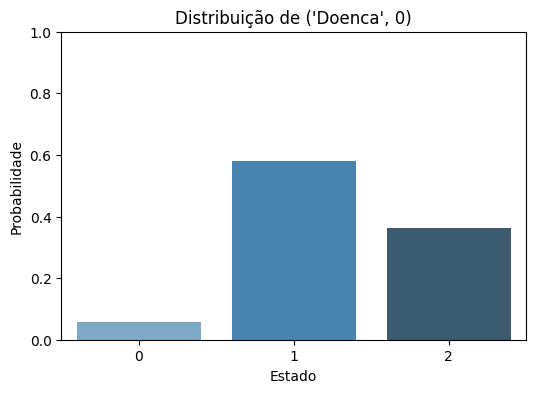

In [ ]:
# Gráficos de barra automáticos para visualizar os resultados das inferências

%matplotlib inline

def plot_inference_result(query_result, variable_name):
    """
    Função para plotar um gráfico de barras para os resultados de inferência.
    """
    # Se for dict, pega o fator correspondente
    if isinstance(query_result, dict):
        result = query_result[variable_name]
    else:
        result = query_result

    prob_values = result.values
    states = result.state_names[variable_name]

    df = pd.DataFrame({'Estado': states, 'Probabilidade': prob_values})

    plt.figure(figsize=(6,4))
    sns.barplot(data=df, x='Estado', y='Probabilidade', palette='Blues_d')
    plt.title(f'Distribuição de {variable_name}')
    plt.ylim(0, 1)
    plt.show()

plot_inference_result(query, ('Doenca', 0))

<ipython-input-14-ea092d5d8b78>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Estado', y='Probabilidade', palette='Blues_d', ax=axes[idx])
<ipython-input-14-ea092d5d8b78>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Estado', y='Probabilidade', palette='Blues_d', ax=axes[idx])


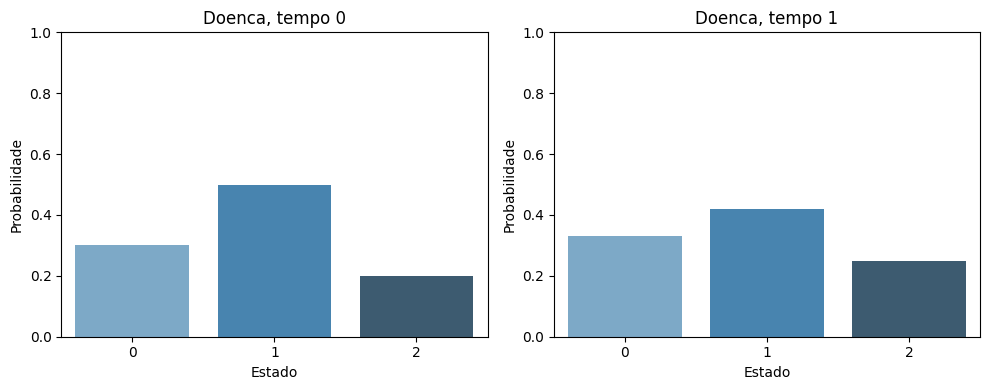

In [ ]:
%matplotlib inline

def plot_inference_multiple_times(infer, variable_name, times):
    """
    Plota gráficos de inferência lado a lado para múltiplos tempos.

    infer: objeto de inferência (DBNInference)
    variable_name: nome da variável (string), ex: 'Doenca'
    times: lista de tempos, ex: [0, 1, 2]
    """
    n = len(times)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4))

    for idx, t in enumerate(times):
        query_result = infer.query(variables=[(variable_name, t)])

        # Se for dict, pega o fator correspondente
        if isinstance(query_result, dict):
            result = query_result[(variable_name, t)]
        else:
            result = query_result

        prob_values = result.values
        states = result.state_names[(variable_name, t)]

        df = pd.DataFrame({'Estado': states, 'Probabilidade': prob_values})

        sns.barplot(data=df, x='Estado', y='Probabilidade', palette='Blues_d', ax=axes[idx])
        axes[idx].set_title(f'{variable_name}, tempo {t}')
        axes[idx].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

# Exemplo:
plot_inference_multiple_times(dbn_infer, 'Doenca', times=[0, 1])


# Elemento interativo - inferência dinâmica

In [ ]:
""" Elemento interativo com widgets para inferência dinâmica
# Poderá interagir diretamente e ver a distribuição de probabilidades alterando os sintomas nas caixas entre 0 e 1 para febre, tosse e fadiga!

# ------------------------------------------
# Dicionário dos estados
estado_dict = {0: 'Gripe', 1: 'COVID-19', 2: 'Pneumonia'}
estados_modelo = list(estado_dict.values())          # ['Gripe', 'COVID-19', 'Pneumonia']

priors = {'Gripe': 0.30, 'COVID-19': 0.50, 'Pneumonia': 0.20}

# Exemplo de redefinição da CPD raiz :
# from pgmpy.factors.discrete import TabularCPD
# cpd_doenca0 = TabularCPD(
#       variable=('Doenca', 0),
#       variable_card=3,
#       values=[[priors['Gripe']], [priors['COVID-19']], [priors['Pneumonia']]])
# dbn.add_cpds(cpd_doenca0)   # substitui a CPD anterior

# ------------------------------------------
# Função de inferência interativa
def interactive_inference(febre, tosse, fadiga):
    """
    Quando febre=tosse=fadiga=0: estado Saudável com prob 1.
    Caso contrário: roda inferência na DBN e mostra distribuição
    para Gripe / COVID-19 / Pneumonia.
    """

    # Caso "tudo zero"  →  Saudável
    if febre == 0 and tosse == 0 and fadiga == 0:
        df = pd.DataFrame({'Estado': ['Saudável'], 'Probabilidade': [1.0]})
        print(f"\nEvidência: Febre={febre}, Tosse={tosse}, Fadiga={fadiga}")
        print("Resultado da Inferência:\nSaudável: 1.00")
        estado_mais_provavel = 'Saudável'
        prob_max = 1.0
    else:
        # Evidência nos nós de sintomas no tempo 0
        evidence = {('Febre', 0): febre,
                    ('Tosse', 0): tosse,
                    ('Fadiga', 0): fadiga}

        # Inferência
        result = dbn_infer.query(variables=[('Doenca', 0)], evidence=evidence)

        # Compatibilidade pgmpy < 0.2
        if isinstance(result, dict):
            result = result[('Doenca', 0)]

        prob_values = result.values           # numpy array [p0, p1, p2]
        states      = result.state_names[('Doenca', 0)]  # ['0', '1', '2'] ou ints

        # Constrói DataFrame para o gráfico
        df = pd.DataFrame({
            'Estado': [estado_dict[int(s)] for s in states],
            'Probabilidade': prob_values
        })

        # Maior probabilidade
        idx_max = np.argmax(prob_values)
        estado_mais_provavel = estado_dict[int(states[idx_max])]
        prob_max = prob_values[idx_max]

        # Impressão amigável no console
        print(f"\nEvidência: Febre={febre}, Tosse={tosse}, Fadiga={fadiga}")
        print("Resultado da Inferência:")
        for s, p in zip(states, prob_values):
            print(f"{estado_dict[int(s)]}: {p:.2f}")

    # Resumo
    print(f"\n✅ Doença mais provável: **{estado_mais_provavel}** "
          f"com probabilidade de {prob_max:.2%}")

    # Gráfico
    plt.figure(figsize=(6, 4))
    sns.barplot(data=df, x='Estado', y='Probabilidade', palette='coolwarm')
    plt.title("Distribuição de Probabilidade")
    plt.ylim(0, 1)
    plt.show()

# ------------------------------------------
# Widgets interativos
import ipywidgets as widgets
febre_widget  = widgets.ToggleButtons(options=[0, 1], description='Febre')
tosse_widget  = widgets.ToggleButtons(options=[0, 1], description='Tosse')
fadiga_widget = widgets.ToggleButtons(options=[0, 1], description='Fadiga')

widgets.interact(interactive_inference,
                 febre=febre_widget,
                 tosse=tosse_widget,
                 fadiga=fadiga_widget) """


interactive(children=(ToggleButtons(description='Febre', options=(0, 1), value=0), ToggleButtons(description='…

<function __main__.interactive_inference(febre, tosse, fadiga)>